In [2]:
import os
import pathlib
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
import tensorflow_io as tfio
import tensorflow_addons as tfa
import tensorflow.keras.regularizers as regularizers
import scipy

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.`

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/Users/joseph/Desktop/tensorflow-test/env/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ["dlopen(/Users/joseph

In [3]:
DATASET_PATH = '/Users/joseph/Desktop/tensorflow-test/newer-audio'

data_dir = pathlib.Path(DATASET_PATH)

In [4]:
commands = ["real", "fake"]
print('Commands:', commands)

Commands: ['real', 'fake']


In [5]:
fake_filefolders = tf.io.gfile.glob(str(data_dir) + '/fake/*')
real_filefolders = tf.io.gfile.glob(str(data_dir) + '/real/*')
fake_filefolders = tf.random.shuffle(fake_filefolders)
real_filefolders = tf.random.shuffle(real_filefolders)

filefolders = []
filenames = []

for i in range(len(real_filefolders)): # hardcoded because real_filenames is the smaller sample set
    filefolders.append(real_filefolders[i].numpy().decode())
    filefolders.append(fake_filefolders[i].numpy().decode())

for i in range(len(filefolders)):
    filenames.append((tf.io.gfile.glob(filefolders[i] + '/*')))
    
filenames = tf.concat([item for item in filenames], axis = 0)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.glob(str(data_dir) + "/" + commands[0] + '/*/*')))
print(filenames)

2022-01-16 16:18:44.121746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-16 16:18:44.121888: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
Number of total examples: 140800
Number of examples per label: 70400
tf.Tensor(
[b'/Users/joseph/Desktop/tensorflow-test/newer-audio/real/file19236.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/bothshift_audio.wav'
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/real/file19236.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/pitch_audio.wav'
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/real/file19236.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/noisebothshift_audio.wav'
 ...
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/fake/file1161.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/noisepitch_audio.wav'
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/fake/file1161.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/time_audio.wav'
 b'/Users/joseph/Desktop/tensorflow-test/newer-audio/fake/file1161.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec/audio.wav'], shape=(140800,), dtype=string)


In [6]:
train_files = filenames[:round(num_samples*0.8)]
val_files = filenames[round(num_samples*0.8): round(num_samples*0.9)]
test_files = filenames[round(num_samples*0.9):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 112640
Validation set size 14080
Test set size 14080


In [7]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [8]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-3]

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label
# waveform here is a tf tensor with 32000 values

In [10]:
def make_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 32000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [input_len] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tfio.audio.spectrogram(equal_length, nfft = 2048, window = 512, stride = 256)
  mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)  
  dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
  dbscale_mel_spectrogram = dbscale_mel_spectrogram[..., tf.newaxis]
  return dbscale_mel_spectrogram

In [11]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  # log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = spectrogram.shape[0]
  width = spectrogram.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, spectrogram)
  # plt.figure()
  # plt.imshow(tf.math.log(spectrogram).numpy())

In [12]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = make_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [13]:
def freq_masking(spectrogram, label_id):
    spectrogram = tf.squeeze(spectrogram)
    freq_mask = tfio.audio.freq_mask(spectrogram, param=10)   
    freq_mask = freq_mask[..., tf.newaxis]
    return freq_mask, label_id

In [14]:
def time_masking(spectrogram, label_id):
    spectrogram = tf.squeeze(spectrogram)
    time_mask = tfio.audio.time_mask(spectrogram, param=10)
    time_mask = time_mask[..., tf.newaxis]
    return time_mask, label_id

In [15]:
def specaugment(spectrogram, label_id):
        augmented_spec, label_id = freq_masking(spectrogram, label_id)
        augmented_spec, label_id = time_masking(augmented_spec, label_id)
        return augmented_spec, label_id

In [16]:
def normalize_ds(spectrogram, label_id):
    spectrogram = spectrogram + abs(tf.math.reduce_min(spectrogram))
    spectrogram = spectrogram / tf.math.reduce_max(spectrogram)
    return spectrogram, label_id

In [17]:
def preprocess_dataset(files):
  AUTOTUNE = tf.data.AUTOTUNE
    
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  spectrogram_ds = waveform_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  # specaugment_ds = spectrogram_ds.map(
  #     map_func=specaugment,
  #     num_parallel_calls=AUTOTUNE)
  # second_output_ds = spectrogram_ds.concatenate(specaugment_ds)
  output_ds = spectrogram_ds.map(
      map_func=normalize_ds,
      num_parallel_calls=AUTOTUNE)

  output_ds = output_ds.cache().prefetch(AUTOTUNE)
  
  num_elements = tf.data.experimental.cardinality(output_ds).numpy()
  print(num_elements)

  output_ds = output_ds.shuffle(num_elements)
    
  return output_ds

In [18]:
# all_ds = preprocess_dataset(filenames)

# num_elements = tf.data.experimental.cardinality(all_ds).numpy()

# train_size = int(0.8*num_elements)
# val_size = int(0.1*num_elements)
# test_size = int(0.1*num_elements)

# train_ds = all_ds.take(train_size)
# test_ds = all_ds.skip(train_size)
# val_ds = test_ds.skip(test_size)
# test_ds = test_ds.take(test_size)

In [19]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

112640
14080
14080


In [20]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [23]:
input_shape = (125, 128, 1)

model = models.Sequential([

    layers.Flatten(input_shape=input_shape),

    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 16000)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2048128   
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,056,449
Trainable params: 2,056,449
Non-trainable params: 0
_________________________________________________________________


In [21]:
checkpoint_path = "/Users/joseph/Desktop/tensorflow-test/checkpoints/modelvnaught.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

tqdm_callback = tfa.callbacks.TQDMProgressBar()
    
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.losses.binary_crossentropy,
    metrics=['accuracy'],
)

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    verbose=1,
    callbacks=[cp_callback, lr_callback],
)

Epoch 1/60


2022-01-14 17:35:41.957624: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-14 17:35:41.957706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 17:35:51.989738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 9650 of 112640
2022-01-14 17:36:01.991114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 19664 of 112640
2022-01-14 17:36:11.990355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 29752 of 112640
2022-01-14 17:36:21.989936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 39806 of 112640
2022-01-14 17:36:31.989201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (

   4/3520 [..............................] - ETA: 59s - loss: 3.5979 - accuracy: 0.4766      

2022-01-14 17:38:10.707559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


3520/3520 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.5523

2022-01-14 17:39:20.422272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 17:39:30.436746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 4960 of 14080
2022-01-14 17:39:40.444917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 9812 of 14080
2022-01-14 17:39:49.109283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.



Epoch 00001: saving model to /Users/joseph/Desktop/tensorflow-test/checkpoints/modelvnaught.ckpt
3520/3520 [==============================] - 252s 29ms/step - loss: 0.6745 - accuracy: 0.5523 - val_loss: 0.6591 - val_accuracy: 0.5622 - lr: 0.0010
Epoch 2/60
3520/3520 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.5566
Epoch 00002: saving model to /Users/joseph/Desktop/tensorflow-test/checkpoints/modelvnaught.ckpt
3520/3520 [==============================] - 41s 11ms/step - loss: 0.6592 - accuracy: 0.5566 - val_loss: 0.6509 - val_accuracy: 0.5780 - lr: 0.0010
Epoch 3/60
3519/3520 [============================>.] - ETA: 0s - loss: 0.6231 - accuracy: 0.6179
Epoch 00003: saving model to /Users/joseph/Desktop/tensorflow-test/checkpoints/modelvnaught.ckpt
3520/3520 [==============================] - 40s 11ms/step - loss: 0.6231 - accuracy: 0.6179 - val_loss: 0.5855 - val_accuracy: 0.6619 - lr: 0.0010
Epoch 4/60
3519/3520 [============================>.] - ETA: 0s - l

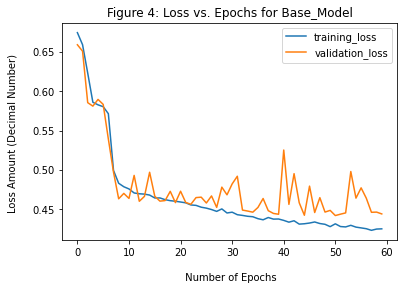

In [62]:
metrics = history.history
fig, ax = plt.subplots()
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title("Figure 4: Loss vs. Epochs for Base_Model")
ax.set_xlabel("\n Number of Epochs")
ax.set_ylabel("Loss Amount (Decimal Number) \n")
plt.show()

In [37]:
print(history.history)

{'loss': [0.6744900345802307, 0.6591656804084778, 0.6230974793434143, 0.5859631896018982, 0.5826969146728516, 0.5803496241569519, 0.5714460611343384, 0.49932652711868286, 0.4829603135585785, 0.4785415530204773, 0.47574856877326965, 0.4706476032733917, 0.46961867809295654, 0.46916434168815613, 0.46795853972435, 0.46427032351493835, 0.46430647373199463, 0.4621325731277466, 0.46084123849868774, 0.4601139724254608, 0.4591437876224518, 0.45809298753738403, 0.45540404319763184, 0.45485347509384155, 0.45253676176071167, 0.451353520154953, 0.4495547115802765, 0.4472200274467468, 0.45035722851753235, 0.4451916813850403, 0.44619083404541016, 0.4429994821548462, 0.4420982301235199, 0.44098687171936035, 0.44043058156967163, 0.43794938921928406, 0.436526358127594, 0.43942132592201233, 0.4373931586742401, 0.4375302791595459, 0.43575650453567505, 0.43352019786834717, 0.43528932332992554, 0.4310216009616852, 0.43149352073669434, 0.4323920011520386, 0.4337470233440399, 0.4317772686481476, 0.43078652024

In [25]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'Test set accuracy: {test_acc:.0%}')

2022-01-13 01:50:29.039123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 6260 of 14080
2022-01-13 01:50:39.048180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 12782 of 14080
2022-01-13 01:50:41.117364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


440/440 - 25s - loss: 0.4392 - accuracy: 0.7960 - 25s/epoch - 57ms/step
Test set accuracy: 80%


In [25]:
import time

save_path = "/Users/joseph/Desktop/tensorflow-test/saved-models/modelvnaught"

new_model = tf.keras.models.load_model(save_path)

new_model.summary()

model = new_model

for i in range(11):

    t0 = time.time()
    loss, acc = new_model.evaluate(test_ds, verbose=2)
    t1 = time.time() 
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    print(t1-t0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 128)               2048128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,056,449
Trainable params: 2,056,449
Non-trainable params: 0
_________________________________________________________________


2022-01-14 05:06:17.260442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


440/440 - 3s - loss: 0.4392 - accuracy: 0.7960 - 3s/epoch - 6ms/step
Restored model, accuracy: 79.60%
2.7925498485565186
440/440 - 3s - loss: 0.4392 - accuracy: 0.7960 - 3s/epoch - 7ms/step
Restored model, accuracy: 79.60%
2.8779349327087402
440/440 - 3s - loss: 0.4392 - accuracy: 0.7960 - 3s/epoch - 6ms/step
Restored model, accuracy: 79.60%
2.6175220012664795
440/440 - 3s - loss: 0.4392 - accuracy: 0.7960 - 3s/epoch - 7ms/step
Restored model, accuracy: 79.60%
2.907067060470581
440/440 - 3s - loss: 0.4392 - accuracy: 0.7960 - 3s/epoch - 6ms/step
Restored model, accuracy: 79.60%
2.6711509227752686
440/440 - 3s - loss: 0.4392 - accuracy: 0.7960 - 3s/epoch - 6ms/step
Restored model, accuracy: 79.60%
2.782961845397949
440/440 - 3s - loss: 0.4392 - accuracy: 0.7960 - 3s/epoch - 6ms/step
Restored model, accuracy: 79.60%
2.839040994644165
440/440 - 3s - loss: 0.4392 - accuracy: 0.7960 - 3s/epoch - 6ms/step
Restored model, accuracy: 79.60%
2.6850390434265137
440/440 - 3s - loss: 0.4392 - accur

In [23]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.round(preds))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2022-01-13 21:51:16.043270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


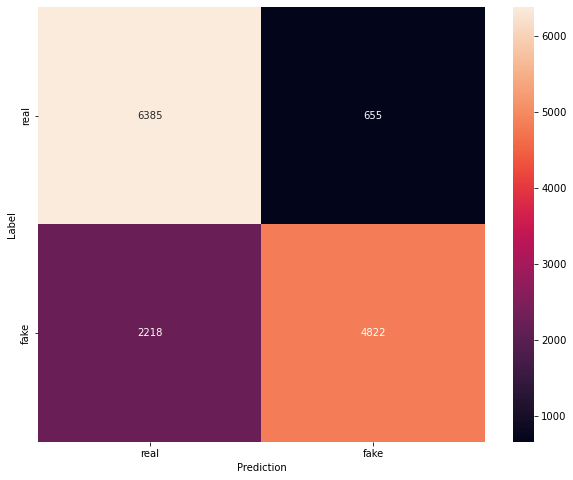

In [24]:
confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [28]:
# save_path = "/Users/joseph/Desktop/tensorflow-test/saved-models/modelvnaught"
# model.save(save_path)

2022-01-13 01:51:02.295602: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/joseph/Desktop/tensorflow-test/saved-models/modelvnaught/assets


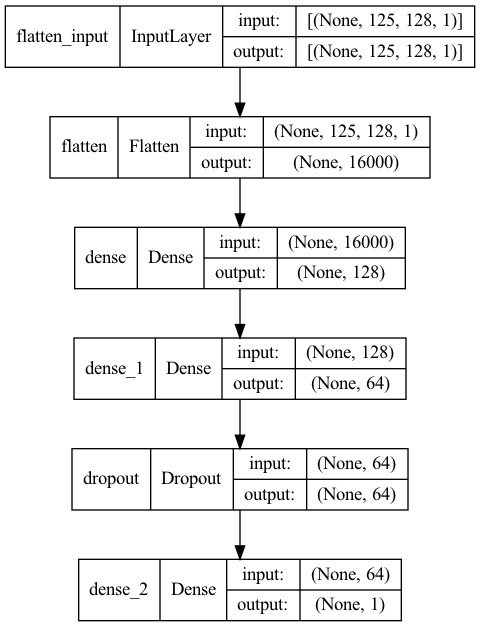

In [30]:
# tf.keras.utils.plot_model(model, to_file="/Users/joseph/Desktop/tensorflow-test/architectures/modelvnaught_structure.png", show_shapes=True)